In [65]:
import numpy as np
import pandas as pd
import statistics
import math
import randfor_functions as rf
import matplotlib.pyplot as plt
import re
import datetime as dt

In [38]:
engage = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')

In [39]:
engage.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [40]:
#Cut this because it's not adding any information, it's just always 1
engage.drop(axis = 1, labels = 'visited', inplace = True)

In [41]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
#It's possible that email domain is predictive. We'll check that. Don't need name, though,
#we have user id already.

In [42]:
users.email[0]

'AugustCClausen@yahoo.com'

In [43]:
email = []
for index, row in users.iterrows():
    email.append(re.findall('\@(.*)', row.email)[0])
users.email=email

In [50]:
users.email.value_counts()[:8]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xybhi.com            2
dqwln.com            2
Name: email, dtype: int64

In [ ]:
#Don't want corellated variables here. Testing three, one at a time.

In [53]:
users['gmail'] = [domain == 'gmail.com' for domain in users['email']]
users['yahoo'] = [domain == 'yahoo.com' for domain in users['email']]
users['other'] = [(domain != 'yahoo.com' and domain != 'gmail.com') for domain in users['email']]

In [56]:
users.drop(axis = 1, labels = 'name', inplace = True)
users.drop(axis = 1, labels = 'email', inplace = True)

In [58]:
users.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [ ]:
#Split this up

In [60]:
users['org_invite'] = [invite == 'ORG_INVITE' for invite in users['creation_source']]
users['guest_invite'] = [invite == 'GUEST_INVITE' for invite in users['creation_source']]
users['other_invite'] = [(invite != 'ORG_INVITE' and invite != 'GUEST_INVITE') for invite in users['creation_source']]

In [62]:
users.drop(axis = 1, labels = 'creation_source', inplace = True)

In [67]:
engage.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


In [63]:
users.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,gmail,yahoo,other,org_invite,guest_invite,other_invite
0,1,2014-04-22 03:53:30,1.398139e+09,1,0,11,10803.0,False,True,False,False,True,False
1,2,2013-11-15 03:45:04,1.396238e+09,0,0,1,316.0,False,False,True,True,False,False
2,3,2013-03-19 23:14:52,1.363735e+09,0,0,94,1525.0,False,False,True,True,False,False
3,4,2013-05-21 08:09:28,1.369210e+09,0,0,1,5151.0,False,True,False,False,True,False
4,5,2013-01-17 10:14:20,1.358850e+09,0,0,193,5240.0,False,True,False,False,True,False


In [71]:
users.last_session_creation_time.isna().any()

True

In [ ]:
#Fill nans with unix timestamp of their creation time

In [82]:
adjusted_session = []
date_format = '%Y-%m-%d %H:%M:%S'
unix_start = dt.datetime(1970,1,1)
for index, row in users.iterrows():
    if math.isnan(row.last_session_creation_time):
        adjusted_session.append((dt.datetime.strptime(row.creation_time, date_format)-unix_start).total_seconds())
    else:
        adjusted_session.append(row.last_session_creation_time)

In [83]:
users.last_session_creation_time = adjusted_session

In [ ]:
#Add column: Time between account creation and last login

In [86]:
session_distance = []
date_format = '%Y-%m-%d %H:%M:%S'
for index, row in users.iterrows():
    time = dt.datetime.utcfromtimestamp(row.last_session_creation_time)
    session_distance.append((time - dt.datetime.strptime(row.creation_time, date_format)).total_seconds())

In [87]:
users['session_distance'] = session_distance

In [ ]:
#Convert start time to something machine-learning readable: days from min start

In [138]:
date_format = '%Y-%m-%d %H:%M:%S'
first = dt.datetime.strptime(min(users.creation_time), date_format)
days_from_first = []
for index, row in users.iterrows():\
    days_from_first.append((dt.datetime.strptime(row.creation_time, date_format)-first).days)

In [139]:
users['days_from_first'] = days_from_first

In [150]:
users.invited_by_user_id.fillna(0, inplace=True)

In [ ]:
#Data cleaning complete. Determining which users adopted.

In [91]:
engage.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


In [94]:
dt.datetime(2000, 1, 1) - dt.datetime(2000, 1, 8)

datetime.timedelta(days=-7)

In [96]:
dt.timedelta(days=7)

datetime.timedelta(days=7)

In [121]:
#Sort through all logins by a user and return true if they logged in at least 3 time in
#one week. False otherwise.
def did_engage(all_logins):
    all_logins.reset_index(inplace = True)
    date_format = '%Y-%m-%d %H:%M:%S'
    for x in range(len(all_logins)-2):
        first_login = dt.datetime.strptime(all_logins.time_stamp[x], date_format)
        third_login = dt.datetime.strptime(all_logins.time_stamp[x+2], date_format)
        if third_login - first_login <= dt.timedelta(days=7):
            return True
    return False

In [132]:
adopted_user = []
for user in range(1, 12001):
    all_logins = engage[engage.user_id == user]
    if len(all_logins) < 3:
        adopted_user.append(False)
    else:
        adopted_user.append(did_engage(all_logins))

In [ ]:
#Classification variable set. Let's model.

In [126]:
users.columns

Index(['object_id', 'creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'gmail', 'yahoo', 'other', 'org_invite',
       'guest_invite', 'other_invite', 'session_distance'],
      dtype='object')

In [152]:
ind_vars = users[['days_from_first', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',\
                 'invited_by_user_id', 'gmail', 'org_invite', 'session_distance']]

In [153]:
for x in ind_vars.columns:
    if ind_vars[x].isna().any():
        print(x)

In [ ]:
#All set. Time to model.

In [154]:
rf.randfor_class_talk(ind_vars, adopted_user, 1000, 20, None, 50)

train score: 0.98
test score: 0.969
f1 score 0.8827238335435056
confusion_matrix:
[[2557   29]
 [  64  350]]
precision score: 0.9234828496042217
recall score: 0.8454106280193237
columns: 8
rows: 12000
total data: 96000
feature importances:
session_distance: 0.9656516625947801
days_from_first: 0.013876375898949363
org_id: 0.01277810442436803
invited_by_user_id: 0.005560664343574898
gmail: 0.0006684022911553568
enabled_for_marketing_drip: 0.0005803328484309981
opted_in_to_mailing_list: 0.000538798002454722
org_invite: 0.0003456595962866736
elapsed time: 0:00:08.353170


In [ ]:
#Looks like session distance, time between account creation and most recent login, is far and away
#the most predictive of which users adopt. This is a very good model.
#Session distance seems to be the only thing that really matters here. Going to try removing it,
#seeing what happens.

In [155]:
ind_vars = users[['days_from_first', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',\
                 'invited_by_user_id', 'gmail', 'org_invite']]
rf.randfor_class_talk(ind_vars, adopted_user, 1000, 20, None, 50)

train score: 0.8636666666666667
test score: 0.8596666666666667
f1 score 0.0
confusion_matrix:
[[2579    1]
 [ 420    0]]
precision score: 0.0
recall score: 0.0
columns: 7
rows: 12000
total data: 84000
feature importances:
days_from_first: 0.4140090028727944
org_id: 0.31562378144925346
invited_by_user_id: 0.2065685495195272
gmail: 0.017303620054967328
opted_in_to_mailing_list: 0.016893824570751465
org_invite: 0.01585986296861352
enabled_for_marketing_drip: 0.013741358564092672
elapsed time: 0:00:15.552988


In [ ]:
#Model completely fails to find adopted users without session distance.

In [159]:
#What about just session distance?

In [160]:
ind_vars = users[['session_distance']]
rf.randfor_class_talk(ind_vars, adopted_user, 1000, 20, None, 50)

train score: 0.9753333333333334
test score: 0.9716666666666667
f1 score 0.8936170212765958
confusion_matrix:
[[2558   23]
 [  62  357]]
precision score: 0.9394736842105263
recall score: 0.8520286396181385
columns: 1
rows: 12000
total data: 12000
feature importances:
session_distance: 1.0
elapsed time: 0:00:02.465208


In [ ]:
#Huh.

In [163]:
users['adopted'] = adopted_user

In [175]:
usergroup = users.groupby(adopted_user).mean()
usererror = users.groupby(adopted_user).std()

In [182]:
use_time = usergroup['session_distance']/(60*60*24)
use_error = usererror['session_distance']/(60*60*24)

In [183]:
use_time

False      3.685615
True     292.507850
Name: session_distance, dtype: float64

In [184]:
use_error

False     12.732705
True     206.845348
Name: session_distance, dtype: float64

Text(0.5, 1.0, 'Use time with adopters and non-adopters')

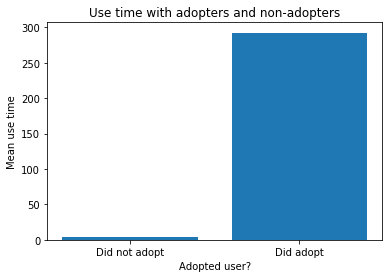

In [181]:
plt.bar(use_time.index, height = use_time.values)
plt.xlabel('Adopted user?')
plt.ylabel('Mean use time')
plt.xticks(np.arange(2), ['Did not adopt', 'Did adopt'])
plt.title('Use time with adopters and non-adopters')

In [189]:
nonadopted = users[users.adopted == False]
nonadopted['session_distance']=nonadopted['session_distance']/(60*60*24)
adopted = users[users.adopted == True]
adopted['session_distance']=adopted['session_distance']/(60*60*24)

C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marcu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Nonadopting users')

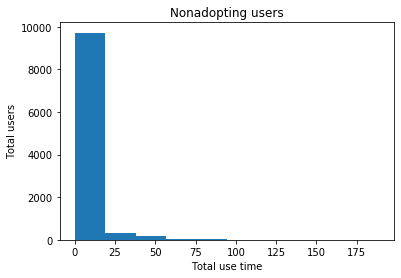

In [192]:
plt.hist(nonadopted.session_distance)
plt.xlabel('Total use time')
plt.ylabel('Total users')
plt.title('Nonadopting users')

Text(0.5, 1.0, 'Adopting users')

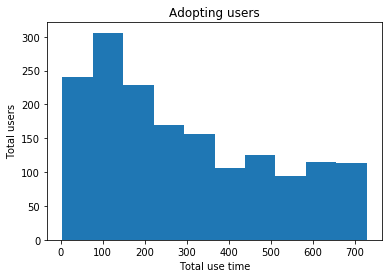

In [194]:
plt.hist(adopted.session_distance)
plt.xlabel('Total use time')
plt.ylabel('Total users')
plt.title('Adopting users')